In [2]:
import numpy as np
from astropy.io import fits 
from astropy.nddata import Cutout2D
from astropy import wcs
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.modeling import models, fitting
import matplotlib.pyplot as plt
import copy
from matplotlib import rc
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": 8,
    "axes.titlesize": 8
})
cm = 1/2.54

In [1]:
savedir = "/data/gleam_x/drII_plotting/noise_analysis/"
datadir = "/data/gleam_x/Super_Description_Paper_GLEAM-X/noise_analysis/drii_069_prior"
# freq="170-231"
# freq="072-080"
freq="72-103"
savenm="069"
title="72-103"

In [3]:
# hdu = fits.open(f"{datadir}/GLEAMX_DRII-{freq}MHz.fits")
# im_wcs = wcs.WCS(hdu[0].header, naxis=2)\
# hdu_rms = fits.open(f"{datadir}/GLEAMX_DRII-{freq}MHz_rms.fits")
# rms_wcs = wcs.WCS(hdu_rms[0].header, naxis=2)
# hdu_bkg = fits.open(f"{datadir}/GLEAMX_DRII-{freq}MHz_bkg.fits")
# bkg_wcs = wcs.WCS(hdu_bkg[0].header, naxis=2)

hdu = fits.open(f"{datadir}/XG.fits")
im_wcs = wcs.WCS(hdu[0].header, naxis=2)
hdu_rms = fits.open(f"{datadir}/XG_rms.fits")
rms_wcs = wcs.WCS(hdu_rms[0].header, naxis=2)
hdu_bkg = fits.open(f"{datadir}/XG_bkg.fits")
bkg_wcs = wcs.WCS(hdu_bkg[0].header, naxis=2)




In [1199]:
# hdu[0].data = hdu[0].data - hdu_bkg[0].data

In [4]:
# pos = SkyCoord("04h37m13s -21d21m30s",frame ="icrs")
pos = SkyCoord("02h47m27s -38d48m40s",frame ="icrs")
im_cutout = Cutout2D(hdu[0].data, pos, (15*u.deg, 15*u.deg), wcs=wcs.WCS(hdu[0].header))


im_data = im_cutout.data

In [5]:
bins = 100
nx = np.empty(bins)
stdev = 0.025
nsig = 1

# stdev=1
# nsig=5
xmin = -nsig*stdev
xmax = nsig*stdev

In [6]:
nu, binsu = np.histogram(im_data,bins = np.linspace(xmin,xmax,bins))
# nu, binsu = np.histogram(im_data, bins=bins,density=False)
nu = np.array(nu,dtype="float32")/len(nu)
binsu_centers = (binsu+((binsu[1]-binsu[0])/2))[:-1]
g_init = models.Gaussian1D(amplitude=1., mean=0., stddev=stdev)
fit_g = fitting.LevMarLSQFitter()
gu = fit_g(g_init, binsu_centers, nu)
print("Stdev of original image is {0}Jy/beam (meaningless, here for completeness)".format(gu.stddev.value))
print(gu)
print(min(nu))

# tgu = copy.deepcopy(gu)
# tgu.mean.value = 0.0
# tgu.stddev.value=1.0

Stdev of original image is 0.004122080490284733Jy/beam (meaningless, here for completeness)
Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude               mean                stddev       
    ------------------ --------------------- --------------------
    114.59884791067184 -0.002139676435974196 0.004122080490284733
0.0


In [7]:
tempr = hdu_rms[0].data

rms_cutout = Cutout2D(tempr, pos, (15*u.deg, 15*u.deg), wcs=wcs.WCS(hdu_rms[0].header))


rms_cutout_data = rms_cutout.data
mean_rms = np.nanmean(rms_cutout_data)

print(f"BANE detects {mean_rms} mJy/beam noise in this region.")

tempb = hdu_bkg[0].data
bkg_cutout = Cutout2D(tempb, pos, (15*u.deg, 15*u.deg), wcs=wcs.WCS(hdu_bkg[0].header))


bkg_cutout_data = bkg_cutout.data
mean_bkg = np.nanmean(bkg_cutout_data)

print(f"BANE detects {mean_bkg} mJy/beam bkg in this region.")

tgu = copy.deepcopy(gu)
tgu.mean.value = mean_bkg
tgu.stddev.value = mean_rms
# tgu.stddev.value=1.0
# tgu.mean.value = 0.0

BANE detects 0.004509655758738518 mJy/beam noise in this region.
BANE detects -0.001549108070321381 mJy/beam bkg in this region.


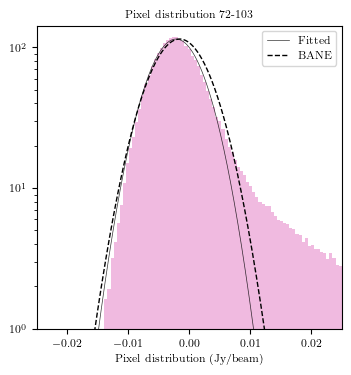

In [8]:
fig = plt.figure(figsize=(10*cm, 10*cm))
ax = fig.add_subplot(111)
ax.bar(binsu_centers, nu, color = 'C6', edgecolor = "none", width=(binsu[1]-binsu[0]),alpha=0.5) 
# ax.hist(im_data,density=False,bins=100)
ax.set_yscale('log')
ax.set_xlabel("Pixel distribution (Jy/beam)")
ax.set_xlim([xmin,xmax])
ax.set_ylim([1.0,1.2*max(nu)])
# ax.set_ylim([1.0,2.8e2])
# ax.axvline(gu.mean.value, color='k')
# ax.axvline(mean_bkg, color='k',linestyle="--")
# ax.axvline(mean_bkg-(2*mean_rms), color='k',linestyle=":")
# ax.axvline(mean_bkg+(2*mean_rms), color='k',linestyle=":")
ax.plot(np.linspace(xmin,xmax,1000),gu(np.linspace(xmin,xmax,1000)), color='k',lw=0.5, alpha=0.8, label='Fitted')

ax.plot(np.linspace(xmin,xmax,1000),tgu(np.linspace(xmin,xmax,1000)), color='k',lw=1, linestyle="--", label='BANE')
ax.legend()
ax.set_title(f"Pixel distribution {title}")
plt.savefig(f"{savedir}/noise_distribution_{savenm}.png")

In [774]:
tempr = hdu_rms[0].data

rms_cutout = Cutout2D(tempr, pos, (15*u.deg, 15*u.deg), wcs=wcs.WCS(hdu_rms[0].header))


rms_cutout_data = rms_cutout.data
mean_rms = np.nanmedian(rms_cutout_data)

print(f"BANE detects {mean_rms} Jy/beam noise in this region.")

tempb = hdu_bkg[0].data
bkg_cutout = Cutout2D(tempb, pos, (18*u.deg, 18*u.deg), wcs=wcs.WCS(hdu_bkg[0].header))


bkg_cutout_data = bkg_cutout.data
mean_bkg = np.nanmedian(bkg_cutout_data)

print(f"BANE detects {mean_bkg} Jy/beam bkg in this region.")


BANE detects 0.004526018630713224 Jy/beam noise in this region.
BANE detects -0.0015627399552613497 Jy/beam bkg in this region.


In [682]:
freq="170-231"

In [683]:
# hdu = fits.open(f"{datadir}/GLEAMX_DRII-072-103MHz.fits")
hdu = fits.open(f"{datadir}/GLEAMX_DRII-{freq}MHz.fits")
im_wcs = wcs.WCS(hdu[0].header, naxis=2)

hdu_rms = fits.open(f"{datadir}/GLEAMX_DRII-{freq}MHz_rms.fits")
rms_wcs = wcs.WCS(hdu_rms[0].header, naxis=2)

hdu_bkg = fits.open(f"{datadir}/GLEAMX_DRII-{freq}MHz_bkg.fits")
bkg_wcs = wcs.WCS(hdu_bkg[0].header, naxis=2)

In [684]:
hdu[0].data = hdu[0].data - hdu_bkg[0].data

ValueError: operands could not be broadcast together with shapes (29414,48565) (1280,2113) 

In [685]:

im_cutout = Cutout2D(hdu[0].data, pos, (15*u.deg, 15*u.deg), wcs=wcs.WCS(hdu[0].header))


im_data = im_cutout.data

In [679]:
bins = 75
nx = np.empty(bins)
stdev = 0.002
nsig = 6
xmin = -nsig*stdev
xmax = nsig*stdev

In [680]:
nu, binsu = np.histogram(im_data,bins = np.linspace(xmin,xmax,bins))
# nu, binsu = np.histogram(im_data, bins=bins,density=False)
nu = np.array(nu,dtype="float32")/len(nu)
binsu_centers = (binsu+((binsu[1]-binsu[0])/2))[:-1]
g_init = models.Gaussian1D(amplitude=1., mean=0., stddev=stdev)
fit_g = fitting.LevMarLSQFitter()
gu = fit_g(g_init, binsu_centers, nu)
print("Stdev of original image is {0}Jy/beam (meaningless, here for completeness)".format(gu.stddev.value))
print(gu)
print(min(nu))

Stdev of original image is 0.0008121786929041584Jy/beam (meaningless, here for completeness)
Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude              mean                  stddev       
    ----------------- ---------------------- ---------------------
    31510.66278437633 -0.0001589440691959988 0.0008121786929041584
2.162162


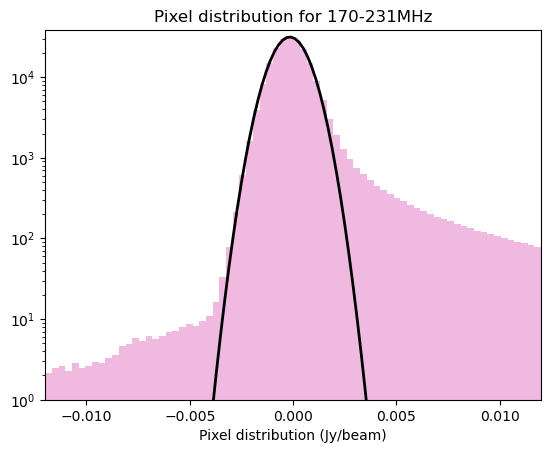

In [681]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(binsu_centers, nu, color = 'C6', edgecolor = "none", width=(binsu[1]-binsu[0]),alpha=0.5) 
# ax.hist(im_data,density=False,bins=100)
ax.set_yscale('log')
ax.set_xlabel("Pixel distribution (Jy/beam)")
ax.set_xlim([xmin,xmax])
ax.set_ylim([1.0,1.2*max(nu)])

ax.plot(np.linspace(-0.1,0.1,1000),gu(np.linspace(-0.1,0.1,1000)), color='k',lw=2, label='BANE')
ax.set_title(f"Pixel distribution for {freq}MHz")
plt.savefig(f"{datadir}/noise_distribution_srcfdr.png")

In [601]:
tempr = hdu_rms[0].data

rms_cutout = Cutout2D(tempr, pos, (5*u.deg, 5*u.deg), wcs=wcs.WCS(hdu_rms[0].header))


rms_cutout_data = rms_cutout.data
mean_rms = np.nanmedian(rms_cutout_data)

print(f"BANE detects {mean_rms} Jy/beam noise in this region.")

tempb = hdu_bkg[0].data
bkg_cutout = Cutout2D(tempb, pos, (5*u.deg, 5*u.deg), wcs=wcs.WCS(hdu_bkg[0].header))


bkg_cutout_data = bkg_cutout.data
mean_bkg = np.nanmedian(bkg_cutout_data)

print(f"BANE detects {mean_bkg} Jy/beam bkg in this region.")



BANE detects 0.0007888845284469426 Jy/beam noise in this region.
BANE detects -9.957029396900907e-05 Jy/beam bkg in this region.
